In [12]:
import networkx as nx
import networkx.algorithms.community
import igraph as ig
import leidenalg
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score

## Functions

In [ ]:
def modularity(G, communities):

    '''For undirected graphs'''

    Q = 0
    m = G.number_of_edges()
    
    for community in communities:
        subgraph = G.subgraph(community)
        L_c=subgraph.number_of_edges()         
        k_c=sum(dict(G.degree(community)).values())  
        
        Q+=(L_c/m)-(k_c/(2*m))**2

    return Q

def assortivity_coeff(G,communities):

    '''For undirected graphs'''

    Q = 0
    m = G.number_of_edges()
    Q_max=1
    
    for community in communities:
        subgraph = G.subgraph(community)
        L_c=subgraph.number_of_edges()         
        k_c=sum(dict(G.degree(community)).values())  
        
        Q+=(L_c/m)-(k_c/(2*m))**2
        Q_max-=(k_c/(2*m))**2
         
    return Q/Q_max

## Loading Graph

In [14]:
# Loading the graph using networkx
G = nx.read_edgelist("com-amazon.ungraph.txt",nodetype=int)

In [15]:
#Chacking number of connected components
nx.number_connected_components(G)

1

In [16]:
print(len(list(nx.find_cliques(G))))
print(nx.density(G))
print(max(*list(nx.find_cliques(G)),key=len))

470042
1.6513834036534368e-05
[840, 386597, 78680, 515449, 195877, 315704, 369028]


## Leiden

In [17]:
# Converting Graph to Igraph
G_ig = ig.Graph.TupleList(G.edges(), directed=False, vertex_name_attr="name")
leiden_partition = leidenalg.find_partition(G_ig, leidenalg.ModularityVertexPartition)
index_to_name = G_ig.vs["name"]

leiden_communities_named = [[index_to_name[i] for i in comm] for comm in leiden_partition]


In [18]:
print("Leiden Communities")
print("Number of communities:",len(leiden_communities_named))
print(modularity(G,leiden_communities_named))
print(assortivity_coeff(G,leiden_communities_named))
print()


Leiden Communities
Number of communities: 374
0.931873190384581
0.9450233915365108



## Fixing GT communities

In [19]:
communities = []

with open('com-amazon.all.dedup.cmty.txt', 'r') as f:
    for line in f:
        community = set(map(int, line.strip().split()))
        communities.append(community)

print(len(communities))

75149


In [20]:
seen = set()
duplicates = set()

for comm in communities:
    for node in comm:
        if node in seen:
            duplicates.add(node)
        else:
            seen.add(node)

print(f"Number of duplicated nodes: {len(duplicates)}")

Number of duplicated nodes: 301594


In [21]:
#Merging Communities
threshold=0.7

communities=sorted(communities, key=len, reverse=True)
used=[False]*len(communities)
merged_communities=[]

for i,comm_i in tqdm(enumerate(communities), total=len(communities), desc="Merging"):
    if used[i]:
        continue
    base=set(comm_i)
    used[i]=True
    for j in range(i+1,len(communities)):
        if used[j]:
            continue
        comm_j=communities[j]
        if not base&comm_j:
            continue  
        jacc=len(base&comm_j)/len(base|comm_j)
        if jacc>threshold:
            base|=comm_j
            used[j]=True
    merged_communities.append(base)

#Removing overlapping nodes
merged_communities=sorted(merged_communities,key=len,reverse=True)
new_communities=[]

for com_i in tqdm(merged_communities,total=len(merged_communities),desc="Removing Overlapping nodes"):
    for com_j in new_communities:
        com_i = com_i-(com_i & com_j)  # Removing overlapping nodes
    if com_i:
        new_communities.append(com_i)

Removing Overlapping nodes: 100%|██████████| 62099/62099 [00:15<00:00, 4028.93it/s] 


In [22]:
union = set()

for comm in new_communities:
    union.update(comm)

missing_nodes = set(G.nodes) - union
print("Missing nodes:", missing_nodes)

if len(union) == len(G.nodes):
    print("WOOOOOOO")
else:
    print("Some nodes are NOT in any community.")

Missing nodes: {32768, 229377, 65543, 131079, 294922, 360467, 360469, 524309, 229399, 131096, 327703, 327704, 98331, 65564, 491547, 32798, 393247, 131104, 458782, 360483, 458787, 426021, 229415, 327721, 393257, 163884, 491564, 229424, 49, 360497, 426037, 196663, 360503, 196665, 229434, 524346, 294972, 524347, 327742, 393279, 262209, 426051, 68, 294982, 163912, 327752, 98382, 229458, 229461, 294997, 458842, 98396, 98397, 196702, 426078, 196704, 229472, 131170, 163939, 360545, 393315, 327786, 65644, 458860, 327790, 113, 131186, 163960, 131197, 32894, 295037, 327805, 65665, 426109, 426113, 295044, 458880, 524417, 131207, 524422, 426121, 229514, 229516, 262285, 32913, 163985, 393361, 65686, 98455, 458903, 196763, 426140, 98461, 458907, 262305, 393378, 524452, 458917, 295078, 458920, 295083, 491692, 196781, 32944, 131250, 458935, 65725, 295101, 360638, 229568, 327873, 426176, 458943, 196, 491710, 524479, 360650, 426188, 327885, 426193, 32978, 229587, 360658, 426195, 393430, 229591, 196824, 

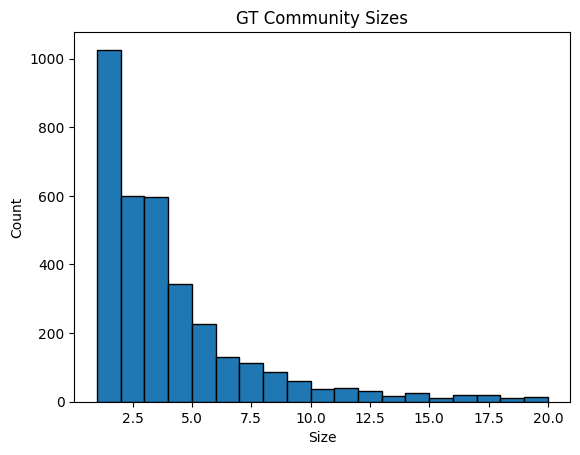

In [23]:
# Adding missing nodes 
new_communities.append(missing_nodes)

gt_sizes = [len(c) for c in new_communities]
plt.hist(gt_sizes, bins=range(1, 21), edgecolor='black')
plt.title("GT Community Sizes")
plt.xlabel("Size")
plt.ylabel("Count")
plt.show()

In [24]:
community_labels = {i: comm for i, comm in enumerate(new_communities)}
print(len(community_labels)) # Number of new communities

3596


In [25]:
node_class = {}

for i, comm in community_labels.items():
    for node in comm:
        node_class[node] = i

print("Total nodes in graph:", len(G.nodes))
print("Nodes in node_class:", len(node_class))
missing_nodes = set(G.nodes) - set(node_class)
print("Missing nodes:", missing_nodes)

Total nodes in graph: 334863
Nodes in node_class: 334863
Missing nodes: set()


In [26]:
# Building look up table for nodes and respective gt communities
node_class = {}
for i, comm in community_labels.items():
    for node in comm:
        node_class[node] = i

# leiden_nodes = set().union(*leiden_communities_named)
# node_class_nodes = set(node_class)

# missing_nodes = leiden_nodes - node_class_nodes

# print("Nodes in leiden_communities:", len(leiden_nodes))
# print("Nodes in node_class:", len(node_class))
# print("Missing nodes (will cause KeyError):", missing_nodes)
# print("Number of missing nodes:", len(missing_nodes))


In [27]:
predicted_node_class={}

for ind_comm in range(len(leiden_communities_named)):
    for i in leiden_communities_named[ind_comm]:
        predicted_node_class[i]=ind_comm


In [28]:
node_classes_in_communties = []

for comm in leiden_communities_named:
    class_set = set()
    for node in comm:
        class_set.add(node_class[node])  
    node_classes_in_communties.append(class_set)

print(type(node_class))

<class 'dict'>


In [29]:
# ARI and NMi measures for comaprison of GT and leiden comms
true_labels=[node_class[node] for node in G.nodes]
pred_labels=[predicted_node_class[node] for node in G.nodes]
ari = adjusted_rand_score(true_labels, pred_labels)
nmi = normalized_mutual_info_score(true_labels, pred_labels)
print(ari)
print(nmi)

0.1358462917302429
0.46920214303404156


## New measure for checking community detection

3596
3596
374
0.15991913110734837


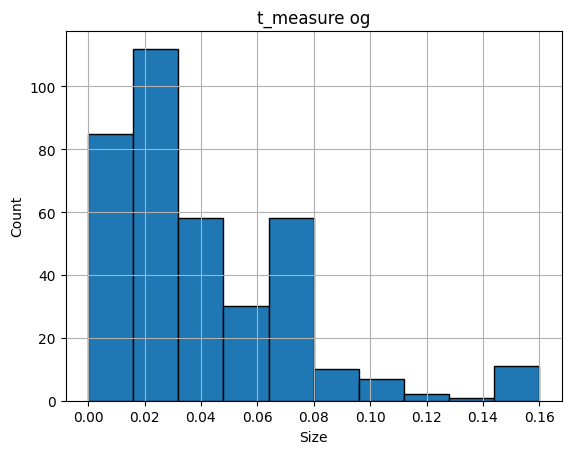

In [30]:
xi_communities=np.array([len(i) for i in new_communities])/len(G.nodes)
t_measure=np.zeros(len(leiden_communities_named),dtype="float")
print(len(xi_communities))
print(len(community_labels))
print(len(node_classes_in_communties))
for comm_i in range(len(node_classes_in_communties)):
    comm=node_classes_in_communties[comm_i]
    len_comm=len(comm)
    t=0
    for i in range(len(community_labels)):
        t+=xi_communities[i]*list(node_classes_in_communties[comm_i]).count(i)/len_comm
    t_measure[comm_i]=t

print(max(t_measure))
plt.hist(t_measure, edgecolor='black')
plt.title("t_measure og")
plt.xlabel("Size")
plt.ylabel("Count")
plt.grid()
plt.show()

3596
3596
374
0.5043494253426236


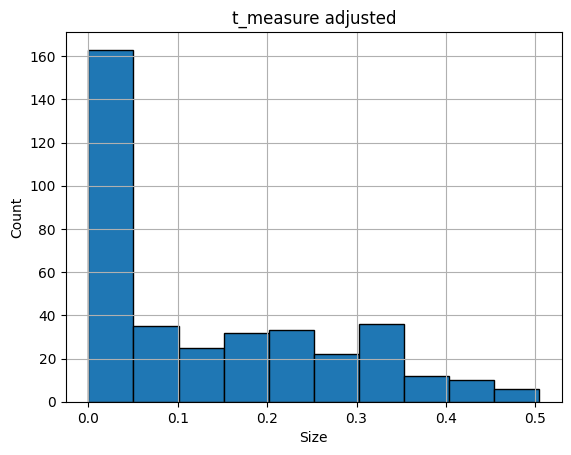

In [31]:
xi_communities=np.array([len(i) for i in new_communities])
t_measure=np.zeros(len(leiden_communities_named),dtype="float")
print(len(xi_communities))
print(len(community_labels))
print(len(node_classes_in_communties))
for comm_i in range(len(node_classes_in_communties)):
    comm=node_classes_in_communties[comm_i]
    len_comm=len(comm)
    t=0
    for i in range(len(community_labels)):
        count=list(node_classes_in_communties[comm_i]).count(i)
        t+=(count/xi_communities[i])*count/len_comm
    t_measure[comm_i]=t

# print(count/xi_communities[i])
# print(count/len_comm)
print(max(t_measure))
plt.hist(t_measure, edgecolor='black')
plt.title("t_measure adjusted")
plt.xlabel("Size")
plt.ylabel("Count")
plt.grid()
plt.show()

0.5


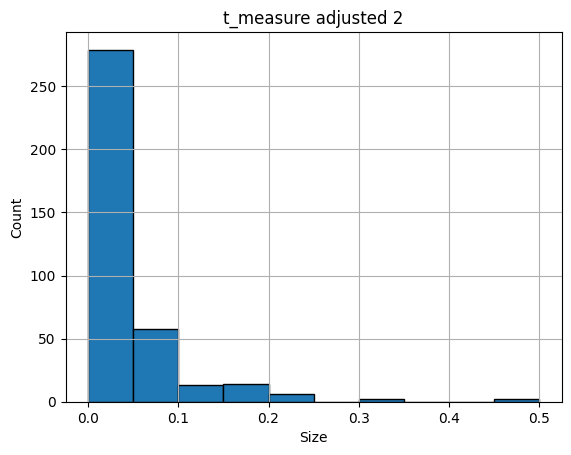

In [32]:
xi_communities=np.array([len(i) for i in new_communities])
t_measure=np.zeros(len(leiden_communities_named),dtype="float")

for comm_i in range(len(node_classes_in_communties)):
    comm=node_classes_in_communties[comm_i]
    len_comm=len(comm)
    t=0
    t_measure[comm_i]=t
    for i in range(len(community_labels)):
        count=list(node_classes_in_communties[comm_i]).count(i)
        t=(count/xi_communities[i])*count/len_comm
        if t>t_measure[comm_i]:
            t_measure[comm_i]=t
    

# print(count/xi_communities[i])
# print(count/len_comm)
print(max(t_measure))
plt.hist(t_measure, edgecolor='black')
plt.title("t_measure adjusted 2")
plt.xlabel("Size")
plt.ylabel("Count")
plt.grid()
plt.show()

## Segregating only internally connected and Externally connected nodes for checking quality of communities

In [33]:
nodes_to_check_incoms=[]
extconnectednodes_incoms=[]
for i in leiden_communities_named:
    S=G.subgraph(i)
    nodes_to_check=[]
    ext_nodes_to_check=[]
    for node in S.nodes:
        if S.degree(node)!=G.degree(node):
            nodes_to_check.append(node)
        else:
            ext_nodes_to_check.append(node)

    nodes_to_check_incoms.append(nodes_to_check)
    extconnectednodes_incoms.append(ext_nodes_to_check)

In [34]:
checkremovedno=[]
for i in range(len(nodes_to_check_incoms)):
    len_ogcomm=len(leiden_communities_named[i])
    len_reducedcomm=len(nodes_to_check_incoms[i])
    checkremovedno.append(len_ogcomm-len_reducedcomm)

print(checkremovedno)

[9941, 8757, 7525, 7658, 6248, 6225, 6450, 4416, 4510, 4165, 5201, 3910, 5445, 4775, 3871, 4019, 4016, 3685, 3814, 3320, 3469, 2986, 3305, 2851, 3158, 3037, 3104, 2482, 2397, 2641, 2178, 2808, 2238, 2234, 2238, 2583, 2091, 2325, 2332, 2244, 2035, 2353, 1839, 1728, 1827, 2086, 2157, 1893, 2014, 2140, 1936, 1590, 1831, 1653, 2005, 1805, 1775, 1477, 1612, 1710, 1510, 1490, 1314, 1595, 1272, 1397, 1327, 1369, 1546, 1285, 1280, 1385, 1066, 1291, 1066, 1268, 1064, 949, 1163, 1053, 1000, 864, 806, 1081, 856, 919, 930, 868, 869, 926, 875, 770, 864, 809, 664, 586, 820, 794, 766, 745, 683, 587, 583, 758, 666, 661, 608, 582, 580, 571, 595, 591, 586, 549, 548, 471, 556, 478, 382, 437, 377, 385, 455, 467, 414, 407, 393, 355, 387, 356, 365, 371, 302, 353, 354, 314, 310, 309, 314, 315, 252, 276, 279, 291, 275, 245, 270, 240, 253, 217, 209, 221, 241, 224, 211, 178, 193, 186, 164, 162, 174, 151, 144, 140, 135, 129, 124, 117, 106, 102, 114, 103, 98, 106, 80, 93, 80, 82, 82, 78, 80, 74, 78, 70, 76, 67, 6

In [35]:
node_classes_in_communties = []

for comm in extconnectednodes_incoms:
    class_set = set()
    for node in comm:
        class_set.add(node_class[node])  
    node_classes_in_communties.append(class_set)

print(type(node_class))

<class 'dict'>


0.15991913110734837
0.5192449183054196
0.5


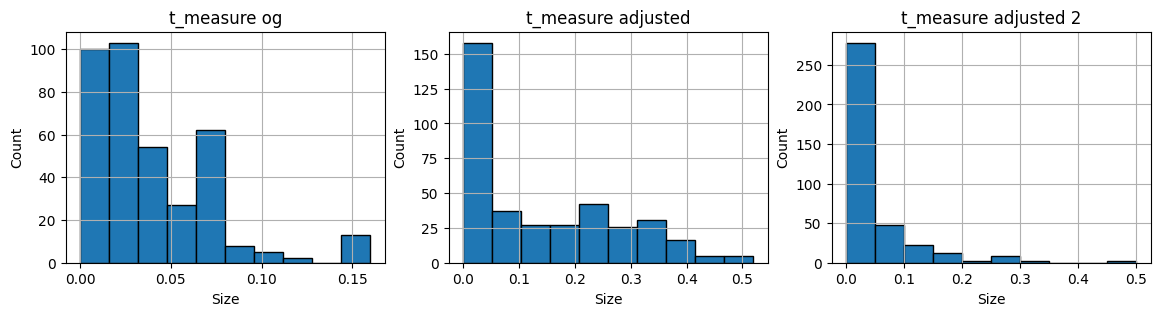

In [36]:
xi_communities=np.array([len(i) for i in new_communities])/len(G.nodes)
t_measure=np.zeros(len(nodes_to_check_incoms),dtype="float")

for comm_i in range(len(node_classes_in_communties)):
    comm=node_classes_in_communties[comm_i]
    len_comm=len(comm)
    t=0
    for i in range(len(community_labels)):
        t+=xi_communities[i]*list(node_classes_in_communties[comm_i]).count(i)/len_comm
    t_measure[comm_i]=t

xi_communities=np.array([len(i) for i in new_communities])
t_measure_adj=np.zeros(len(nodes_to_check_incoms),dtype="float")

for comm_i in range(len(node_classes_in_communties)):
    comm=node_classes_in_communties[comm_i]
    len_comm=len(comm)
    t=0
    for i in range(len(community_labels)):
        count=list(node_classes_in_communties[comm_i]).count(i)
        t+=(count/xi_communities[i])*count/len_comm
    t_measure_adj[comm_i]=t

xi_communities=np.array([len(i) for i in new_communities])
t_measure_adj_2=np.zeros(len(nodes_to_check_incoms),dtype="float")

for comm_i in range(len(node_classes_in_communties)):
    comm=node_classes_in_communties[comm_i]
    len_comm=len(comm)
    t=0
    for i in range(len(community_labels)):
        count=list(node_classes_in_communties[comm_i]).count(i)
        t=(count/xi_communities[i])*count/len_comm
        if t>t_measure[comm_i]:
            t_measure_adj_2[comm_i]=t

print(max(t_measure))
print(max(t_measure_adj))
print(max(t_measure_adj_2))

plt.figure(figsize=(14,3))

plt.subplot(1,3,1)
plt.hist(t_measure, edgecolor='black')
plt.title("t_measure og")
plt.xlabel("Size")
plt.ylabel("Count")
plt.grid()

plt.subplot(1,3,2)
plt.hist(t_measure_adj, edgecolor='black')
plt.title("t_measure adjusted")
plt.xlabel("Size")
plt.ylabel("Count")
plt.grid()

plt.subplot(1,3,3)
plt.hist(t_measure_adj_2, edgecolor='black')
plt.title("t_measure adjusted 2")
plt.xlabel("Size")
plt.ylabel("Count")
plt.grid()
plt.show()


## Matrix comparison thing


In [37]:
node_classes_in_communties = []

for comm in nodes_to_check_incoms:
    class_set = set()
    for node in comm:
        class_set.add(node_class[node])  
    node_classes_in_communties.append(class_set)

print(type(node_class))

<class 'dict'>


1.0


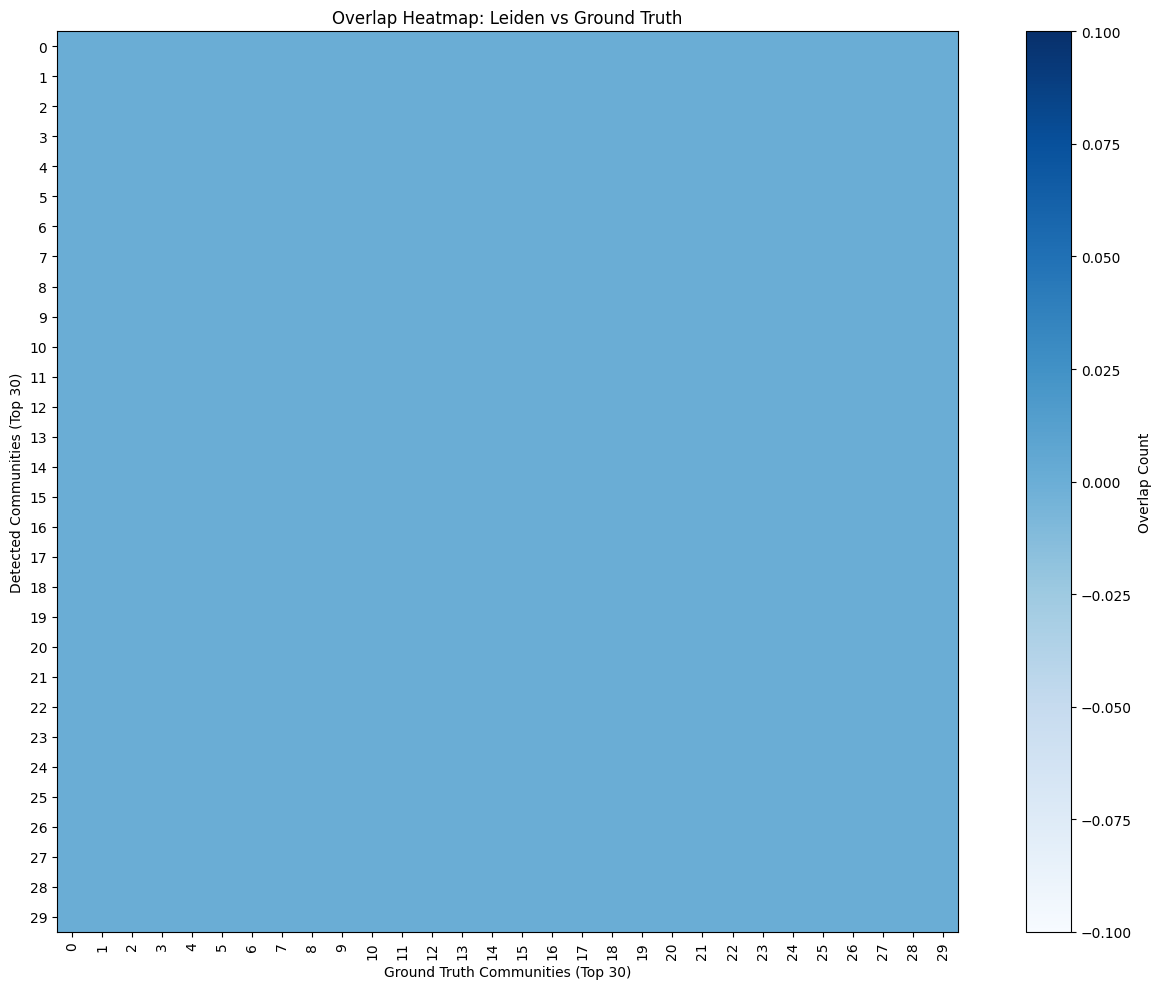

In [ ]:
# new_communities = [set of node IDs for each GT community]
# node_classes = [set of node IDs for each detected community]
new_communities=sorted(new_communities,key=len,reverse=True)
nodes_to_check_incoms=sorted(nodes_to_check_incoms,key=len,reverse=True)

num_true_classes=len(new_communities)
num_detected=len(node_classes_in_communties)
max_overlap=0

# Initializing confusion matrix
confusion=np.zeros((num_detected, num_true_classes), dtype=int)

# Checking oberlaps
for i, detected in enumerate(nodes_to_check_incoms):
    for j, true in enumerate(new_communities):
        overlap = len(set(detected) & set(true))/len(set(true))
        confusion[i, j] = overlap
        if overlap>max_overlap:
            max_overlap=overlap

print(max_overlap)
# Comparing top 30 GT communities and detected communities by total overlaps
# top_gt = np.argsort(np.sum(confusion, axis=0))[::-1][:300]
# top_detected = np.argsort(np.sum(confusion, axis=1))[::-1][:300]
top_detected=np.arange(0,30,1)
top_gt=np.arange(0,30,1)

# Reduced matrix
reduced_confusion = confusion[np.ix_(top_detected, top_gt)]

# Plotting
plt.figure(figsize=(14, 10))
plt.imshow(reduced_confusion, cmap='Blues')
plt.colorbar(label="Overlap Count")
plt.xlabel("Ground Truth Communities (Top 30)")
plt.ylabel("Detected Communities (Top 30)")
plt.title("Overlap Heatmap: Leiden vs Ground Truth")
plt.xticks(ticks=np.arange(len(top_gt)), labels=top_gt, rotation=90)
plt.yticks(ticks=np.arange(len(top_detected)), labels=top_detected)
plt.tight_layout()
plt.show()